## Decision tree model on Amazon Fine Food Reviews

### Importing all Libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import graphviz 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from gensim.models import Word2Vec
from sklearn import preprocessing
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from prettytable import PrettyTable
warnings.filterwarnings("ignore")


### Loading the data

In [2]:
# Loading the cleaned data directly which is preprocessed and stored in final.sqlite
import sqlite3
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [3]:
#Sorting based on time
cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time']).sort_values()

In [4]:
# Splitting the data

X = cleaned_data['CleanedText']
Y = cleaned_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)

(254919,) (109252,)


### Word2Vec

In [ ]:
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
pickle.dump(w2v_words, open( "w2v_train_DT.p", "wb" ))

In [6]:
w2v_words = pickle.load( open( "w2v_train_DT.p", "rb" ))
w2v_words.shape

(18848,)

In [14]:
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_model.wv.most_similar('tast')
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
pickle.dump(w2v_words, open( "w2v_test_DT.p", "wb" ))

In [7]:
w2v_words = pickle.load( open( "w2v_test_DT.p", "rb" ))
w2v_words.shape

(13054,)

### Average Word2Vec

In [ ]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)

#saving sent_vectors as pickle file
pickle.dump(sent_vectors, open( "Avgw2v_train_DT.p", "wb" ))


In [8]:
sent_vectors = pickle.load( open( "Avgw2v_train_DT.p", "rb" ))
sent_vectors.shape

(254919, 50)

In [ ]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
pickle.dump(sent_vectors_test, open( "Avgw2v_test_DT.p", "wb" ))

In [9]:
sent_vectors_test = pickle.load( open( "Avgw2v_test_DT.p", "rb" ))
sent_vectors_test.shape

(109252, 50)

In [10]:
X_train = sent_vectors
X_test = sent_vectors_test

#### GridSearch CV

In [11]:
param_grid = {'max_depth': [3,5,7,9,11,13,15,17,19]}
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), param_grid, cv=tscv)
model.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=19, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Text(0.5,1,'CV Error Vs Max-depth')

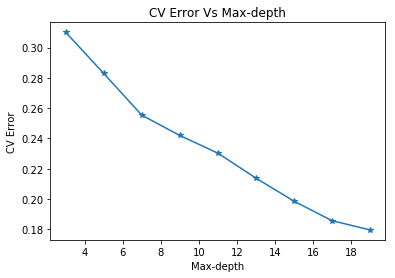

In [13]:
model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
MSE = [1 - x for x in model_mean_scores]

plt.plot([3,5,7,9,11,13,15,17,19], MSE,marker = '*')
plt.xlabel('Max-depth')
plt.ylabel('CV Error')
plt.title('CV Error Vs Max-depth')

In [14]:
max_depth_avgw2v = model.best_estimator_.max_depth
accuracy_avgw2v = model.best_score_*100
print("The accuracy of the model with max_depth {0} is {1}%".format(max_depth_avgw2v,accuracy_avgw2v))

The accuracy of the model with max_depth 19 is 82.03078661206045%


In [21]:
#clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v)
# fitting the model
model_avgw2v = model.best_estimator_.fit(X_test,Y_test)

#Predicting the output
Y_pred = model.best_estimator_.predict(X_test)

# classification report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

   negative       0.82      1.00      0.90     17265
   positive       1.00      0.96      0.98     91987

avg / total       0.97      0.96      0.97    109252



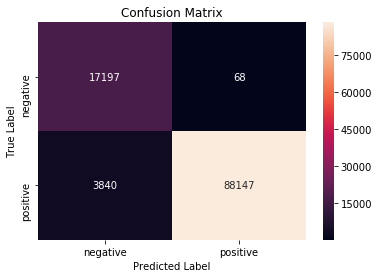

In [22]:
#Confusion matrix

class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, Y_pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
dot_data = tree.export_graphviz(model_avgw2v, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('Avgw2v_DT',view=True)


'Avgw2v_DT.png'

### TF-IDF Word2Vec

In [16]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [22]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
pickle.dump(tfidf_sent_vectors, open( "tfidf_train_DT.p", "wb" ))

In [28]:
tfidf_sent_vectors = pickle.load( open( "tfidf_train_DT.p", "rb" ))
tfidf_sent_vectors.shape

(254919, 50)

In [25]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
pickle.dump(tfidf_sent_vectors_test, open( "tfidf_test_DT.p", "wb" ))

In [29]:
tfidf_sent_vectors_test = pickle.load( open( "tfidf_test_DT.p", "rb" ))
tfidf_sent_vectors_test.shape

(109252, 50)

In [30]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test

In [31]:
param_grid = {'max_depth': [3,5,7,9,11,13,15,17,19]}
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), param_grid, cv=tscv)
model.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=19, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Text(0.5,1,'CV Error Vs Max-depth')

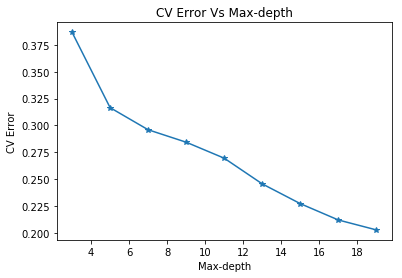

In [33]:
model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
MSE = [1 - x for x in model_mean_scores]

plt.plot([3,5,7,9,11,13,15,17,19], MSE,marker = '*')
plt.xlabel('Max-depth')
plt.ylabel('CV Error')
plt.title('CV Error Vs Max-depth')

In [34]:
max_depth_tfidfw2v = model.best_estimator_.max_depth
accuracy_tfidfw2v = model.best_score_*100
print("The accuracy of the model with max_depth {0} is {1}%".format(max_depth_tfidfw2v,accuracy_tfidfw2v))

The accuracy of the model with max_depth 19 is 79.72179070752719%


In [41]:
#clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v)
# fitting the model
model_tfidfw2v = model.best_estimator_.fit(X_test,Y_test)

#Predicting the output
Y_pred = model.best_estimator_.predict(X_test)

# classification report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

   negative       0.78      1.00      0.88     17265
   positive       1.00      0.95      0.97     91987

avg / total       0.96      0.96      0.96    109252



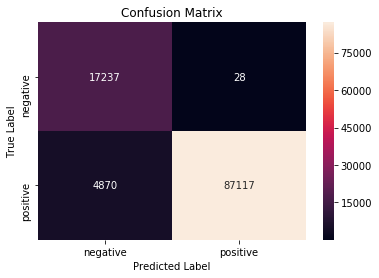

In [42]:
#Confusion matrix

class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, Y_pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [43]:
dot_data = tree.export_graphviz(model_tfidfw2v, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('tfidfw2v_DT',view=True)


'tfidfw2v_DT.png'

In [44]:
#Sampling 30k points

final_data = cleaned_data.sample(n=50000)
final_data.shape
final_data['Score'].value_counts()

positive    42070
negative     7930
Name: Score, dtype: int64

In [45]:
# sorting the data based on time

final_data['Time'] = pd.to_datetime(final_data['Time']).sort_values()
#final_data.head()

### Bag Of Words

In [48]:
# Splitting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(35000,) (15000,)


pandas.core.series.Series

In [49]:
# converting text to vector using Bag of Words
unigram_bow = CountVectorizer()

#Train vectorizer
X_train = unigram_bow.fit_transform(X_train)

#Test vectorizer
X_test = unigram_bow.transform(X_test)

print(X_train.shape,X_test.shape)


(35000, 23169) (15000, 23169)


In [50]:
param_grid = {'max_depth': [3,5,7,9,11,13,15,17,19]}
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), param_grid, cv=tscv)
model.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=19, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Text(0.5,1,'CV Error Vs Max-depth')

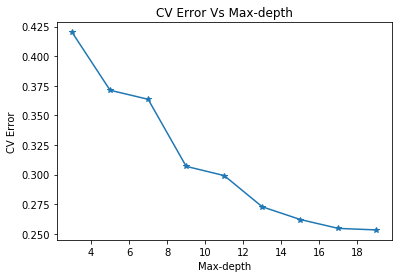

In [52]:
model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
MSE = [1 - x for x in model_mean_scores]

plt.plot([3,5,7,9,11,13,15,17,19], MSE,marker = '*')
plt.xlabel('Max-depth')
plt.ylabel('CV Error')
plt.title('CV Error Vs Max-depth')

In [53]:
max_depth_bow = model.best_estimator_.max_depth
accuracy_bow = model.best_score_*100
print("The accuracy of the model with max_depth {0} is {1}%".format(max_depth_bow,accuracy_bow))

The accuracy of the model with max_depth 19 is 74.66483799074233%


In [54]:
#clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v)
# fitting the model
model_bow = model.best_estimator_.fit(X_test,Y_test)

#Predicting the output
Y_pred = model.best_estimator_.predict(X_test)

# classification report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

   negative       0.47      0.91      0.62      2324
   positive       0.98      0.82      0.89     12676

avg / total       0.90      0.83      0.85     15000



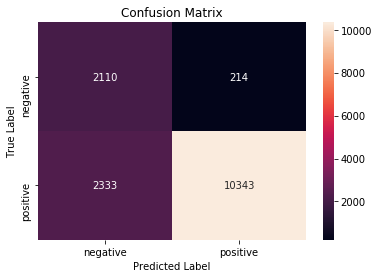

In [55]:
#Confusion matrix

class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, Y_pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [70]:
dot_data = tree.export_graphviz(model_bow, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('bow_DT',view=True)


'bow_DT.png'

### TF-IDF 

In [57]:
#Spltting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(35000,) (15000,)


pandas.core.series.Series

In [58]:
#Converting text to vector using TF-IDF vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))

#Train vectorizer
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
print(X_train.shape,X_test.shape)

(35000, 603734) (15000, 603734)


In [59]:
param_grid = {'max_depth': [3,5,7,9,11,13,15,17,19]}
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), param_grid, cv=tscv)
model.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Text(0.5,1,'CV Error Vs Max-depth')

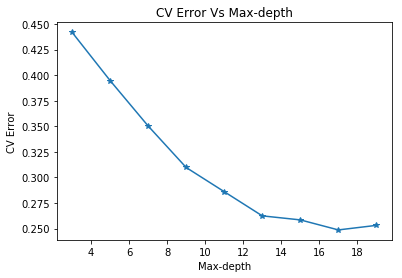

In [61]:
model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
MSE = [1 - x for x in model_mean_scores]

plt.plot([3,5,7,9,11,13,15,17,19], MSE,marker = '*')
plt.xlabel('Max-depth')
plt.ylabel('CV Error')
plt.title('CV Error Vs Max-depth')

In [62]:
max_depth_tfidf = model.best_estimator_.max_depth
accuracy_tfidf = model.best_score_*100
print("The accuracy of the model with max_depth {0} is {1}%".format(max_depth_tfidf,accuracy_tfidf))

The accuracy of the model with max_depth 17 is 75.13800788616493%


In [63]:
#clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v)
# fitting the model
model_tfidf = model.best_estimator_.fit(X_test,Y_test)

#Predicting the output
Y_pred = model.best_estimator_.predict(X_test)

# classification report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

   negative       0.41      0.94      0.57      2324
   positive       0.99      0.75      0.85     12676

avg / total       0.90      0.78      0.81     15000



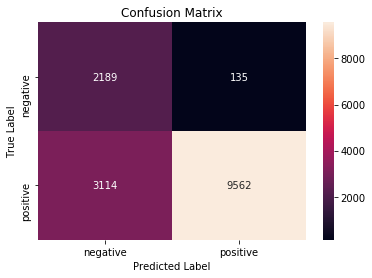

In [64]:
#Confusion matrix

class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, Y_pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [69]:
dot_data = tree.export_graphviz(model_tfidf, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'
graph.render('tfidf_DT',view=True)


'tfidf_DT.png'

In [68]:
x = PrettyTable()

x.field_names = ["Vectorisation", "Max_Depth", "F1-score"]

x.add_row(["BOW",max_depth_bow, '0.85'])

x.add_row(["TF-IDF",max_depth_tfidf,'0.81'])

x.add_row(["Average W2V",max_depth_avgw2v,'0.97'])

x.add_row(["TF-IDF W2V",max_depth_tfidfw2v,'0.96'])


print(x)

+---------------+-----------+----------+
| Vectorisation | Max_Depth | F1-score |
+---------------+-----------+----------+
|      BOW      |     19    |   0.85   |
|     TF-IDF    |     17    |   0.81   |
|  Average W2V  |     19    |   0.97   |
|   TF-IDF W2V  |     19    |   0.96   |
+---------------+-----------+----------+


### Conclusions

* Decision tree worked well on Amazon food reviews 
* All the vectorisation techinques classified the negative and positive labels correctly with minimum misclassification
* Out of all vectorisations Average Word2Vec performed well.
* Decision trees is faster in its traning time than other algorithms like KNN, Logistic, SVM.